# Active selection of points

In [1]:
# setup the code
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import numpy.ma as ma
from sklearn import random_projection
from itertools import groupby
from heapq import heappush, heappop
import random
from sklearn import svm
from pylab import rcParams
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils import check_random_state
import statsmodels.api as sm
import urllib
import os
from sklearn.datasets import load_svmlight_file

from collections import defaultdict

from __future__ import division

# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

In [8]:
# Some helper code
def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# define some utility functions
def plotHyperplane(normal, intercept=0, label='', plt=plt):
    """ Plot a hyperplane given a normal and an intercept
    """
    a = -normal[0] / normal[1]
    xx = np.linspace(-10, 10)
    yy = a * xx - (intercept) / normal[1]    
    plt.plot(xx, yy, label=label)        

class Hasher:
    """Hasher class"""
    
    def generateBitString(self, x ):
        return "".join(['1' if i > 0 else '0' for i in x])    
    
    def randomVector(self):
        components = self.rng.normal(loc=0.0,
                            scale=1.0,
                            size=(self.bits, self.features + 1))
        return components
    
    def query(self, q):
        S = np.sum(np.abs(q)**2,axis=-1)**(1./2)
        sums = 0#;(1 - S / self.maxNorm)**(1./2)
        P = np.hstack((q, sums)) 

        print S
        
        #print P
        if self.bias:
            r = [self.generateBitString((np.dot(P, proj.T ) + self.intercepts[idx].T ).ravel()) for idx, proj in enumerate(self.projections)]        
        else:
            r = [self.generateBitString(np.dot(P, proj.T )) for proj in self.projections]        
        
        return r
            
            
    def __init__(self, bits, X, rnd=42, hashes=1, bias=True, uniform=False, mode='pos'):
        self.bits = bits
        self.rng = check_random_state(rnd) 
        self.rng.seed(rnd)        
        self.features = X.shape[1]
        self.projections = [self.randomVector() for variable in range(hashes)]   
        self.bias = bias
        
        ## append to X
        ## normalized norm
        S = np.sum(np.abs(X)**2,axis=-1)**(1./2)
        self.maxNorm = np.max(S)
        #print np.max(S)
        #np.hstack((X, S))
        sums = (1 - S.reshape(S.shape[0],1) / np.max(S))**(1./2)

        P = np.hstack((X, sums))        
        
        #print P
        
        if self.bias:
            self.intercepts = [self.rng.randn(bits,1) for variable in range(hashes)]                

        
        if self.bias:
            self.projected = [np.apply_along_axis( self.generateBitString, axis=1, arr=np.dot(P, proj.T ) + self.intercepts[idx].T ) for idx, proj in enumerate(self.projections)]        
        else:
            self.projected = [np.apply_along_axis( self.generateBitString, axis=1, arr=np.dot(P, proj.T )) for proj in self.projections]        
                
        # create index
        self.hashtablepos = defaultdict(lambda: [])
        self.hashtableneg = defaultdict(lambda: [])
        
        it = np.nditer(self.projected, flags=['f_index'])
        while not it.finished:
            #print "%s <%d>" % (str(it[0]), it.index)
            if(Y[it.index] == 1):
                self.hashtablepos[str(it[0])].append(X[it.index])                
            else:
                self.hashtableneg[str(it[0])].append(X[it.index])                
            it.iternext()
            
    
    def __str__(self):
        return 'Hasher %d bits' % (self.bits)
    
    def __repr__(self):
        return str(self)


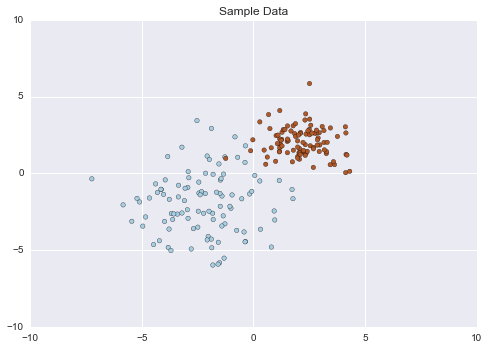

In [3]:
# Now generate some random points
rng = np.random.RandomState(42)
n_samples_1 = 100
n_samples_2 = 100
X = np.r_[2 * rng.randn(n_samples_1, 2) - [2, 2],
          1 * rng.randn(n_samples_2, 2) + [2, 2]]
Y = np.array([0] * (n_samples_1) + [1] * (n_samples_2))

# Permute X and Y
#(X,Y) = shuffle_in_unison_inplace(X,Y)

from sklearn.preprocessing import normalize
#X = normalize(X)#, axis=1, norm='l2')

from sklearn import preprocessing

# = preprocessing.scale(X)
plt.title('Sample Data')
plt.xlim([-10,10])
plt.ylim([-10,10]) 
plt.scatter(X[:,0],X[:,1], c=Y, cmap=plt.cm.Paired, label='Points', vmin=0, vmax=1)
plt.show()

0.940381085791


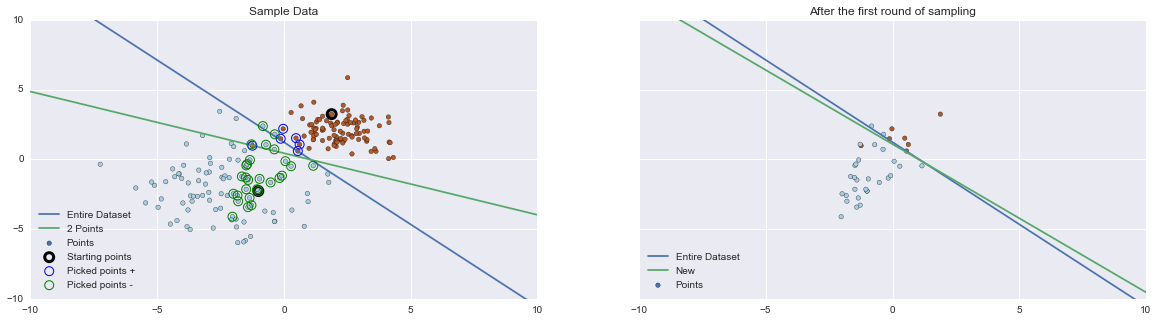

Base       -> 0.985000 with 200 points
Our Method -> 0.985000 with 36 points


In [9]:
# Now hash the points
h = Hasher(4, X, bias=True)

entire = svm.LinearSVC()#(kernel='linear', C=1.0)
entire.fit(X,Y) 

# now pick 2 points from each class ?
x_start = np.vstack((X[0],X[199]))
y_start = np.vstack((Y[0],Y[199])).ravel()
# train svm on the start data
start = svm.LinearSVC()#(kernel='linear', C=1.0)
start.fit(x_start,y_start)  

rcParams['figure.figsize'] = 20, 5
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

ax1.set_title('Sample Data')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10]) 
ax1.scatter(X[:,0],X[:,1], c=Y, cmap=plt.cm.Paired, label='Points', vmin=0, vmax=1)


plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=ax1,label='Entire Dataset')

ax1.scatter(x_start[:, 0], x_start[:, 1], s=80,
                        facecolors='none', zorder=10, label='Starting points', vmin=0, vmax=1, lw = 3)


plotHyperplane(start.coef_[0],start.intercept_[0],plt=ax1,label='2 Points')        

q = h.query(entire.coef_[0])[0]
#print q

# Add pos
if(len(h.hashtablepos[q]) > 0):
    a = np.array(h.hashtablepos[q])

    ax1.scatter(a[:, 0], a[:, 1], s=80,
                            facecolors='none', zorder=10, label='Picked points +', vmin=0, edgecolor='blue', vmax=1, lw = 1)

    x_start = np.vstack((x_start,a))
    y_start = np.append(y_start, np.ones(a.shape[0]))
    
# Add neg
if(len(h.hashtableneg[q]) > 0):
    a = np.array(h.hashtableneg[q])

    ax1.scatter(a[:, 0], a[:, 1], s=80,
                            facecolors='none', zorder=10, label='Picked points -', vmin=0, edgecolor='green', vmax=1, lw = 1)
    
    x_start = np.vstack((x_start,a))
    y_start = np.append(y_start, np.zeros(a.shape[0]))
    
#plt.show()


# now retrain
new = svm.LinearSVC()#(kernel='linear', C=1.0)
new.fit(x_start,y_start)  
#h.hashtablepos

ax2.set_title('After the first round of sampling')
ax2.scatter(x_start[:,0],x_start[:,1], c=y_start, cmap=plt.cm.Paired, label='Points', vmin=0, vmax=1)

plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=ax2,label='Entire Dataset')
plotHyperplane(new.coef_[0],new.intercept_[0],plt=ax2,label='New')        

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')

plt.show()

print('Base       -> %f with %2d points' % (entire.score(X,Y) ,X.shape[0] )) 
print('Our Method -> %f with %2d points' % (new.score(X,Y) ,x_start.shape[0] )) 

